<a href="https://colab.research.google.com/github/sandeepaamcp/privacy-metrics/blob/main/User_diversity_metrics_evaluation_for_MNIST_and_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Observing user diversity metrics in Federated Learning (FL)

To visualise user diversity in FL, directly the diversity among data cannot be used, since data resides private in client devices. Instead, we use model diversity to analyse how diverse the users are. For this, t-SNE based clustering can be used to visualise how the model similarity among clients are varying over the FL full rounds. Moreover, cosine similarity, L1, and L2 distances among the test predictions can also reveal the differences among users.

From the results, it can be observed that the user diversity is high in the initial rounds, meanhwile it tend to decrease with increasing FL rounds.

This code is implemented using Flower FL framework for two datasets, MNIST and CIFAR-10. First, 10 clients were simulated for 10 rounds. Next, the test predictions for each clients at each round is taken. These results were compared using t-SNE, cosine similarity, L1 and L2 distance metrics.

## Installing libraries

In [1]:
!pip install -q flwr[simulation] torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 22.4 MB/s eta 0:00:00


In [2]:
from collections import OrderedDict
from typing import List, Tuple

from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchvision.datasets import MNIST
from torch.utils.data import Subset

from itertools import chain

import csv

from keras.metrics import cosine_similarity

# from sklearn.metrics import roc_curve, auc
from scipy.optimize import curve_fit

import flwr as fl
from flwr.common import Metrics
import random

import statistics

import matplotlib.pyplot as plt
import seaborn as sns

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.4.0


## Selecting and preprocessing of dataset

In [3]:
SELECTED_DATASET = 'MNIST' # CAN USE MNIST OR CIFAR-10

In [4]:
def get_classes():
  CLASSES_CIFAR10 = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
  CLASSES_MNIST = ('1','2','3','4','5','6','7','8','9','0')
  if SELECTED_DATASET =='MNIST':
    return CLASSES_MNIST
  elif SELECTED_DATASET =='CIFAR-10':
    return CLASSES_CIFAR10
  else:
    raise ValueError("Invalid dataset name")

In [5]:
NUM_CLIENTS = 10

In [6]:
BATCH_SIZE = 32

# iid dataset function
def load_datasets(len_train, len_test):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]
    )

    if SELECTED_DATASET == 'MNIST':
      trainset_all = MNIST("./dataset", train=True, download=True, transform=transform)
      testset_all = MNIST("./dataset", train=False, download=True, transform=transform)
    elif SELECTED_DATASET == 'CIFAR-10':
      trainset_all = CIFAR10("./dataset", train=True, download=True, transform=transform)
      testset_all = CIFAR10("./dataset", train=False, download=True, transform=transform)
    else:
      raise ValueError("Invalid dataset name")

    subset_train_indices = range(len_train)
    trainset = Subset(trainset_all, subset_train_indices)

    subset_test_indices = range(len_test)
    testset = Subset(testset_all, subset_test_indices)



    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

In [7]:
# This function is specifically made for non-iid split of dataset. We can define multiple strategies for the split.
def non_iid_split(len_train, len_test, iid_split_strategy, label_list, random_ratio):
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

  if SELECTED_DATASET == 'MNIST':
    trainset_all = MNIST("./dataset", train=True, download=True, transform=transform)
    testset_all = MNIST("./dataset", train=False, download=True, transform=transform)

  elif SELECTED_DATASET == 'CIFAR-10':
    trainset_all = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset_all = CIFAR10("./dataset", train=False, download=True, transform=transform)

  else:
    raise ValueError("Invalid dataset name")

  subset_test_indices = range(len_test)
  testset = Subset(testset_all, subset_test_indices) # iid testset

  partition_size = int(len_train/NUM_CLIENTS)
  lengths = [partition_size] * NUM_CLIENTS


  datasets = iid_split_strategy(trainset_all, lengths, NUM_CLIENTS, label_list, random_ratio)

  # Split each partition into train/val and create DataLoader
  trainloaders = []
  valloaders = []
  for ds in datasets:
      len_val = len(ds) // 10  # 10 % validation set
      len_train = len(ds) - len_val
      lengths = [len_train, len_val]
      ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
      trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
      valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
  testloader = DataLoader(testset, batch_size=BATCH_SIZE)
  return trainloaders, valloaders, testloader


## This strategy is for having non-iid clients with fixed label for each client, while having a portion of small random labels as well
def iid_split_strategy_fixed_label(dataset, client_dataset_len_list, num_clients, label_list, random_ratio):
  all_subsets = []
  for i in range(num_clients):
    target_label = label_list[i]  # Choose the label you want to create a subset for
    limit_per_client = client_dataset_len_list[i]
    random_count = int(limit_per_client * random_ratio)

    if(random_count>limit_per_client):
      print('random count is above 100%. Setting 100% randomness.')
      random_count = limit_per_client

    fixed_count = limit_per_client - random_count
    print('processing client: ', i)
    subset_indices = [idx for idx, (_, label) in enumerate(dataset) if label == target_label][:fixed_count]
    random_indices = random.sample(range(1, len(dataset)), random_count)

    subset_indices.extend(random_indices)
    random.shuffle(subset_indices)
    subset_dataset = Subset(dataset, subset_indices)
    all_subsets.append(subset_dataset)

  return all_subsets

In [9]:
label_list = get_classes()

In [10]:
trainloaders, valloaders, testloader = non_iid_split(10000, 1000, iid_split_strategy_fixed_label, label_list, 0.1)

100%|██████████| 9912422/9912422 [00:00<00:00, 78636879.25it/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9250530.27it/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26671184.17it/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1548949.41it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



processing client:  0
processing client:  1
processing client:  2
processing client:  3
processing client:  4
processing client:  5
processing client:  6
processing client:  7
processing client:  8
processing client:  9


In [11]:
subset_dataset = trainloaders[5].dataset

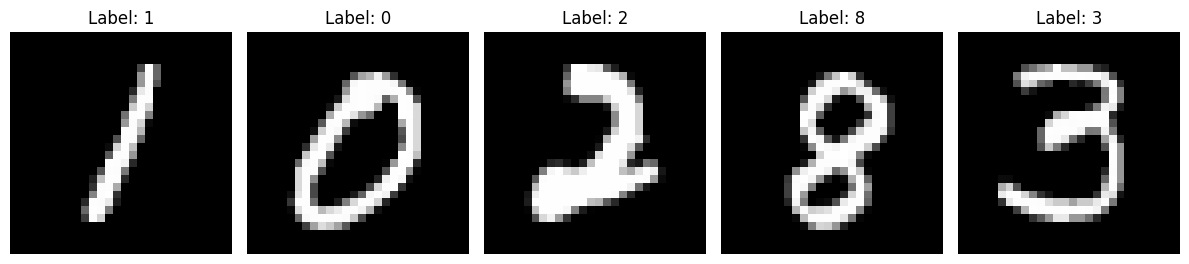

In [12]:
import random
import matplotlib.pyplot as plt

# Define the number of random labels to visualize
num_samples = 5

# Generate random indices for the samples
random_indices = random.sample(range(len(subset_dataset)), num_samples)

# Plot the random labels
fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))

for i, idx in enumerate(random_indices):
    image, label = subset_dataset[idx]
    axes[i].imshow(image[0], cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Define the NN

In [13]:
class Net_CIFAR10(nn.Module):
    def __init__(self) -> None:
        super(Net_CIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        # self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def get_nn():
  if SELECTED_DATASET == 'MNIST':
    return Net_MNIST().to(DEVICE)
  elif SELECTED_DATASET == 'CIFAR-10':
    return Net_CIFAR10().to(DEVICE)
  else:
    raise ValueError("Invalid dataset name")

In [14]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:

            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

def eval(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    real_all = []
    pred_all = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            real_all.append(labels)
            pred_all.append(predicted)
    loss /= len(testloader.dataset)
    accuracy = correct / total
    real_flat = [int(item) for tensor in real_all for item in tensor.view(-1)]
    pred_flat = [int(item) for tensor in pred_all for item in tensor.view(-1)]
    return loss, accuracy, real_flat, pred_flat

In [16]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

## Implementing a Flower client

In [17]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [18]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = get_nn()

    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [19]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [20]:
from logging import WARNING
from typing import Callable, Dict, List, Optional, Tuple, Union
from flwr.server.strategy import FedAvg

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.common.logger import log
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy

from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg
from flwr.server.strategy.strategy import Strategy

class CustomFedAvg(FedAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, Dict[str, Scalar]],
                Optional[Tuple[float, Dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        client_updates_list = [],
        aggregated_updates_list = [],
        results_all=[],
    ) -> None:

        super().__init__()

        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.client_updates_list = client_updates_list
        self.aggregated_updates_list = aggregated_updates_list
        self.results_all = results_all

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Convert results
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        iter_params_dict = {}
        for item, fit_res in results:
          iter_params_dict[item.cid]= (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)

        self.results_all.append(results)
        self.client_updates_list.append(iter_params_dict)
        aggregated_params_arr = aggregate(weights_results)
        parameters_aggregated = ndarrays_to_parameters(aggregated_params_arr)
        self.aggregated_updates_list.append(aggregated_params_arr)

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated

In [21]:
client_updates_list = []
aggregated_updates_list = []
results = []
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    client_updates_list = client_updates_list,
    aggregated_updates_list = aggregated_updates_list,
    results_all = results
)

client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1,"scheduling_strategy":'DEFAULT'}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"log_to_driver": False, "num_cpus": 2, "num_gpus": 0}
)

INFO flwr 2023-07-03 13:41:32,685 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-07-03 13:41:36,461	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-07-03 13:41:38,246 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7802056704.0, 'object_store_memory': 3901028352.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7802056704.0, 'object_store_memory': 3901028352.0}
INFO flwr 2023-07-03 13:41:38,249 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-07-03 13:41:38,255 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
INFO flwr 2023-07-03 1

History (loss, distributed):
	round 1: 0.22548937320709225
	round 2: 0.20464845418930055
	round 3: 0.1634916925430298
	round 4: 0.1383135032653809
	round 5: 0.08934189081192015
	round 6: 0.07053006649017335
	round 7: 0.06808794498443603
	round 8: 0.059365532398223876
	round 9: 0.0703550398349762
	round 10: 0.06960036814212799
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.22000000000000003), (2, 0.28), (3, 0.74), (4, 0.6599999999999999), (5, 0.8800000000000001), (6, 0.8400000000000001), (7, 0.8800000000000001), (8, 0.8800000000000001), (9, 0.78), (10, 0.78)]}

## clustering metrics

In [22]:
def eval_exp(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    real_all = []
    pred_all = []
    outputs_all = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            real_all.append(labels)
            pred_all.append(predicted)
            outputs_all.append(outputs.detach().tolist())
    loss /= len(testloader.dataset)
    accuracy = correct / total
    real_flat = [int(item) for tensor in real_all for item in tensor.view(-1)]
    pred_flat = [int(item) for tensor in pred_all for item in tensor.view(-1)]
    outputs_flat = list(chain(*outputs_all))
    return loss, accuracy, real_flat, pred_flat, outputs_flat

In [23]:
def get_mdl_from_weights(ori_weights):
  model = get_nn()
  weights = [torch.Tensor(weight) for weight in ori_weights]
  model_params = model.state_dict()
  for key, weight in zip(model_params.keys(), weights):
      model_params[key] = weight
  model.load_state_dict(model_params)
  return model

In [24]:
def get_pred_from_models(round_no, testloader, target_client_list, client_updates_list):
  updates_list = client_updates_list[round_no]
  all_pred = []
  all_outputs = []
  for ref_cli in target_client_list:
    print('client ID: ',ref_cli)
    ref_mdl_weights = updates_list[ref_cli][0]
    mdl = get_mdl_from_weights(ref_mdl_weights)
    loss, acc, real, pred, per_cli_output = eval_exp(mdl,testloader)
    pred=np.array(pred)
    all_pred.append(pred)
    all_outputs.append(per_cli_output)
  return all_pred, all_outputs

In [25]:
def get_testloader(len_test):
  transform = transforms.Compose(
          [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]
    )
  subset_test_indices = range(len_test)

  if SELECTED_DATASET == 'MNIST':
      testset_all = MNIST("./dataset", train=False, download=True, transform=transform)

  elif SELECTED_DATASET == 'CIFAR-10':
    testset_all = CIFAR10("./dataset", train=False, download=True, transform=transform)

  else:
    raise ValueError("Invalid dataset name")

  testset = Subset(testset_all, subset_test_indices) # iid testset
  testloader = DataLoader(testset, batch_size=BATCH_SIZE)
  return testloader

In [53]:
all_clients = ['0','1','2','3','4','5','6','7','8','9']
testloader = get_testloader(len_test=100) # for 100 sample testdata

mdl_pred_round, outputs_raw = get_pred_from_models(round_no=0,testloader=testloader, target_client_list=all_clients, client_updates_list=client_updates_list) # here, we check for the FL round 0

client ID:  0
client ID:  1
client ID:  2
client ID:  3
client ID:  4
client ID:  5
client ID:  6
client ID:  7
client ID:  8
client ID:  9


In [54]:
x_results =  list(chain(*outputs_raw))
n = 100  # Number of repetitions for each element
elements = label_list  # Elements to repeat
y_results = [x for x in elements for _ in range(n)]
x_train = np.array(x_results)
y_train = np.array(y_results)

In [57]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x_train)
df = pd.DataFrame()
df["y"] = y_train
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.106359
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.743881
[t-SNE] KL divergence after 1000 iterations: 0.282283


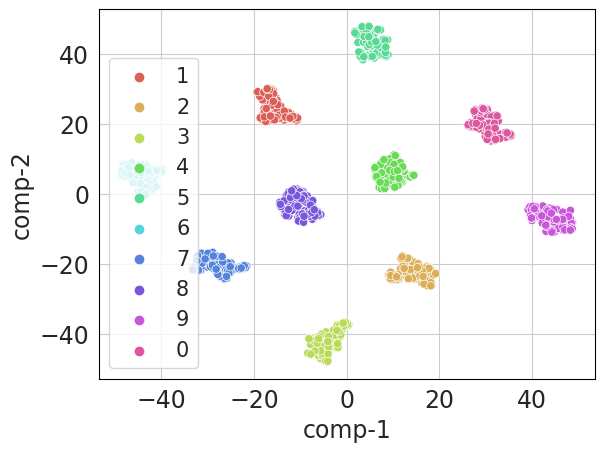

In [58]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df)
plt.legend(fontsize=15, loc='lower left')

## Other similarity metrics

In [32]:
def calc_MAE_MSE_cos_sim(mdl1,mdl2,testloader):
  loss, acc, real1, pred1 = eval(mdl1,testloader)
  loss, acc, real2, pred2 = eval(mdl2,testloader)
  pred1=np.array(pred1)
  pred2=np.array(pred2)
  MAE = np.mean(np.abs(pred1 - pred2))
  MSE = np.mean((pred1 - pred2)**2)

  vector1 = np.array(pred1, dtype=np.float64)
  vector2 = np.array(pred2, dtype=np.float64)

  # Calculate cosine similarity
  cos_sims = cosine_similarity(vector1, vector2)

  avg_cos_sim = np.mean(cos_sims)

  return MAE, MSE, avg_cos_sim
def get_client_updates_cos_sim(ref_cli, classes, client_updates_list, round_no, testloader):

  updates_list = client_updates_list[round_no]
  cos_sim_all = []
  MAE_all = []
  MSE_all = []
  print('Ref client ID: ', ref_cli)
  print('Round No.: ',round_no)
  ref_cli_mdl = updates_list[ref_cli][0]
  for cli in classes:
    print('comparing with class: ', cli)
    if ref_cli!=cli:
      other_mdl = updates_list[cli][0]

      mdl1 = get_mdl_from_weights(ref_cli_mdl)
      mdl2 = get_mdl_from_weights(other_mdl)

      MAE, MSE, avg_cos_sim = calc_MAE_MSE_cos_sim(mdl1,mdl2,testloader)
      MAE_all.append(MAE)
      MSE_all.append(MSE)
      cos_sim_all.append(avg_cos_sim)
  return MAE_all, MSE_all, cos_sim_all

### Analysing distance metrics

In [33]:
def calc_l1_l2(mdl1,mdl2):
  weights1 = np.concatenate([arr.flatten() for arr in mdl1])
  weights2 = np.concatenate([arr.flatten() for arr in mdl2])

  L1_distance = np.sum(np.abs(weights1 - weights2))
  L2_distance = np.sqrt(np.sum((weights1 - weights2)**2))

  # print('L1 distance:', L1_distance)
  # print('L2 distance:', L2_distance)
  return L1_distance, L2_distance

In [34]:
def get_client_updates_l2_dist(ref_cli, classes, client_updates_list, round_no):

  updates_list = client_updates_list[round_no]
  l1_all = []
  l2_all = []
  ref_cli_mdl = updates_list[ref_cli][0]
  for cli in classes:
    if ref_cli!=cli:
      other_mdl = updates_list[cli][0]
      l1, l2 = calc_l1_l2(ref_cli_mdl, other_mdl)
      l1_all.append(l1)
      l2_all.append(l2)
  return l1_all, l2_all

In [35]:
CLASSES_LIST= ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
l1_0, l2_0 = get_client_updates_l2_dist(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=0)
l1_1, l2_1 = get_client_updates_l2_dist(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=1)
l1_3, l2_3 = get_client_updates_l2_dist(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=3)
l1_5, l2_5 = get_client_updates_l2_dist(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=5)
l1_7, l2_7 = get_client_updates_l2_dist(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=7)
l1_9, l2_9 = get_client_updates_l2_dist(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=9)

In [36]:
def draw_graph(x_val, y_vals, markers, x_label, y_label, legend=None, markevery=50, loc='upper left', std_vals=None, is_legend=True):
    sns.set_style('whitegrid')
    sns.set_palette('Dark2')

    plt.rcParams['font.size'] = 17
    plt.rcParams['axes.edgecolor'] = 'black'  # Set the edge color to black
    for i in range(len(y_vals)):
        y = y_vals[i]
        plt.plot(x_val, y, linestyle='--', linewidth=2, marker=markers[i], markevery=markevery)

        if std_vals is not None:
            std = std_vals[i]
            err_plus = [y_val + std_val for y_val, std_val in zip(y, std)]
            err_minus = [y_val - std_val for y_val, std_val in zip(y, std)]
            plt.fill_between(x_val, err_plus, err_minus, alpha=0.3)  # Add shaded region for the standard deviation

    plt.ylabel(y_label, fontsize=20)
    plt.xlabel(x_label, fontsize=20)
    if legend is not None:
      plt.legend(legend, loc=loc, fontsize=14)
    plt.grid(linestyle='dashed')
    plt.xticks(x_val, x_val)

    plt.tight_layout()
    plt.show()


In [37]:
def save_as_csv(rows,filename):
  with open(filename, 'w', newline='') as file:
      writer = csv.writer(file)
      writer.writerows(rows)

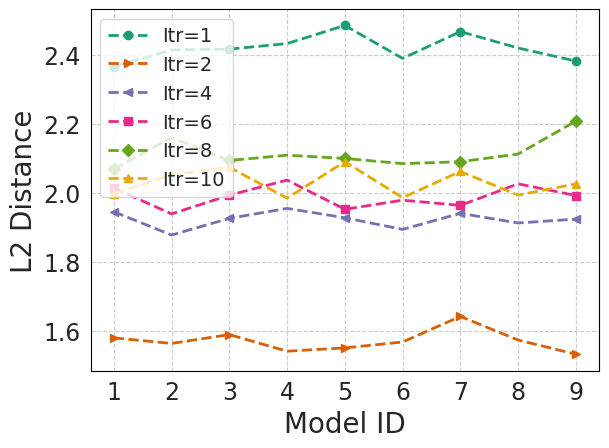

In [38]:
draw_graph(x_val=[i+1 for i in range(9)], y_vals=[l2_0,l2_1,l2_3,l2_5,l2_7,l2_9], markers=['o','>','<','s','D','^'],x_label='Model ID', y_label='L2 Distance',
           legend=['Itr=1','Itr=2','Itr=4','Itr=6','Itr=8','Itr=10'],markevery=2)

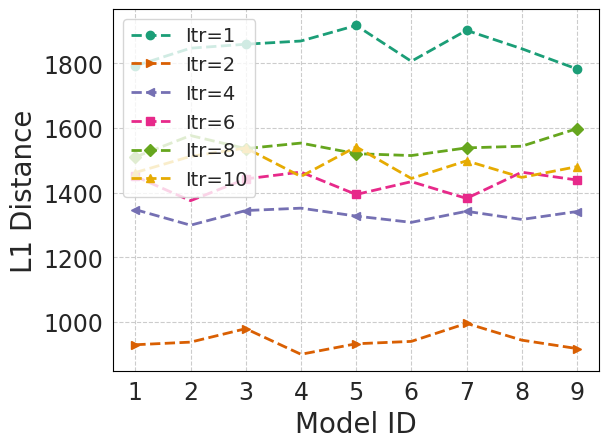

In [39]:
draw_graph(x_val=[i+1 for i in range(9)], y_vals=[l1_0,l1_1,l1_3,l1_5,l1_7,l1_9], markers=['o','>','<','s','D','^'],x_label='Model ID', y_label='L1 Distance',
           legend=['Itr=1','Itr=2','Itr=4','Itr=6','Itr=8','Itr=10'], markevery=2)

In [40]:
l1_mean_vals = [statistics.mean(i) for i in [l1_0,l1_1,l1_3,l1_5,l1_7,l1_9]]
l1_stdev_vals = [statistics.stdev(i) for i in [l1_0,l1_1,l1_3,l1_5,l1_7,l1_9]]

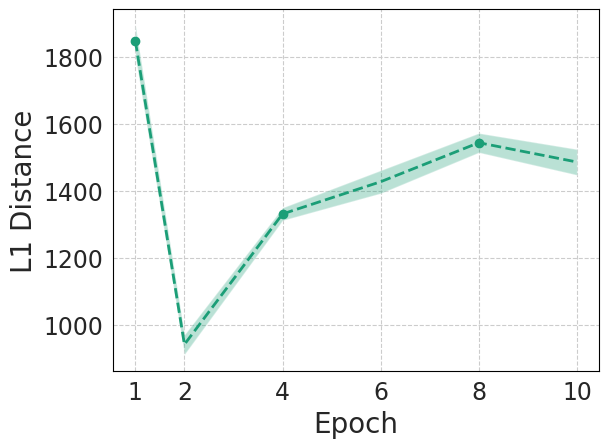

In [43]:
draw_graph(x_val=[1,2,4,6,8,10], y_vals=[l1_mean_vals], markers=['o','>','<','s','D','^'],x_label='Epoch', y_label='L1 Distance',
          std_vals=[l1_stdev_vals], markevery=2)

In [44]:
l2_mean_vals = [statistics.mean(i) for i in [l2_0,l2_1,l2_3,l2_5,l2_7,l2_9]]
l2_stdev_vals = [statistics.stdev(i) for i in [l2_0,l2_1,l2_3,l2_5,l2_7,l2_9]]

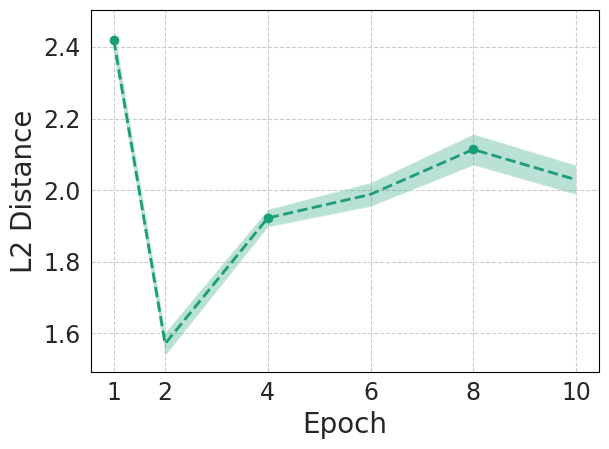

In [45]:
draw_graph(x_val=[1,2,4,6,8,10], y_vals=[l2_mean_vals], markers=['o','>','<','s','D','^'],x_label='Epoch', y_label='L2 Distance',
          std_vals=[l2_stdev_vals], markevery=2)

### cosine similarity

In [46]:
def calc_MAE_MSE_cos_sim(mdl1,mdl2,testloader):
  loss, acc, real1, pred1 = eval(mdl1,testloader)
  loss, acc, real2, pred2 = eval(mdl2,testloader)
  pred1=np.array(pred1)
  pred2=np.array(pred2)
  MAE = np.mean(np.abs(pred1 - pred2))
  MSE = np.mean((pred1 - pred2)**2)

  vector1 = np.array(pred1, dtype=np.float64)
  vector2 = np.array(pred2, dtype=np.float64)

  # Calculate cosine similarity
  cos_sims = cosine_similarity(vector1, vector2)

  avg_cos_sim = np.mean(cos_sims)
  return MAE, MSE, avg_cos_sim

In [47]:
def get_client_updates_cos_sim(ref_cli, classes, client_updates_list, round_no, testloader):

  updates_list = client_updates_list[round_no]
  cos_sim_all = []
  MAE_all = []
  MSE_all = []
  print('Ref client ID: ', ref_cli)
  print('Round No.: ',round_no)
  ref_cli_mdl = updates_list[ref_cli][0]
  for cli in classes:
    print('comparing with class: ', cli)
    if ref_cli!=cli:
      other_mdl = updates_list[cli][0]

      mdl1 = get_mdl_from_weights(ref_cli_mdl)
      mdl2 = get_mdl_from_weights(other_mdl)

      MAE, MSE, avg_cos_sim = calc_MAE_MSE_cos_sim(mdl1,mdl2,testloader)
      MAE_all.append(MAE)
      MSE_all.append(MSE)
      cos_sim_all.append(avg_cos_sim)
  return MAE_all, MSE_all, cos_sim_all

In [48]:
CLASSES_LIST=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
MAE_0, MSE_0, cos_sim_0 = get_client_updates_cos_sim(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=0, testloader=testloader)
MAE_1, MSE_1, cos_sim_1 = get_client_updates_cos_sim(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=1, testloader=testloader)
MAE_3, MSE_3, cos_sim_3 = get_client_updates_cos_sim(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=3, testloader=testloader)
MAE_5, MSE_5, cos_sim_5 = get_client_updates_cos_sim(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=5, testloader=testloader)
MAE_7, MSE_7, cos_sim_7 = get_client_updates_cos_sim(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=7, testloader=testloader)
MAE_9, MSE_9, cos_sim_9 = get_client_updates_cos_sim(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=9, testloader=testloader)

Ref client ID:  0
Round No.:  0
comparing with class:  0
comparing with class:  1
comparing with class:  2
comparing with class:  3
comparing with class:  4
comparing with class:  5
comparing with class:  6
comparing with class:  7
comparing with class:  8
comparing with class:  9
Ref client ID:  0
Round No.:  1
comparing with class:  0
comparing with class:  1
comparing with class:  2
comparing with class:  3
comparing with class:  4
comparing with class:  5
comparing with class:  6
comparing with class:  7
comparing with class:  8
comparing with class:  9
Ref client ID:  0
Round No.:  3
comparing with class:  0
comparing with class:  1
comparing with class:  2
comparing with class:  3
comparing with class:  4
comparing with class:  5
comparing with class:  6
comparing with class:  7
comparing with class:  8
comparing with class:  9
Ref client ID:  0
Round No.:  5
comparing with class:  0
comparing with class:  1
comparing with class:  2
comparing with class:  3
comparing with class: 

In [49]:
cos_sim_mean_vals = [statistics.mean(i) for i in [cos_sim_0,cos_sim_1, cos_sim_3,cos_sim_5,cos_sim_7, cos_sim_9]]
cos_sim_stdev_vals = [statistics.stdev(i) for i in [cos_sim_0,cos_sim_1, cos_sim_3,cos_sim_5,cos_sim_7, cos_sim_9]]

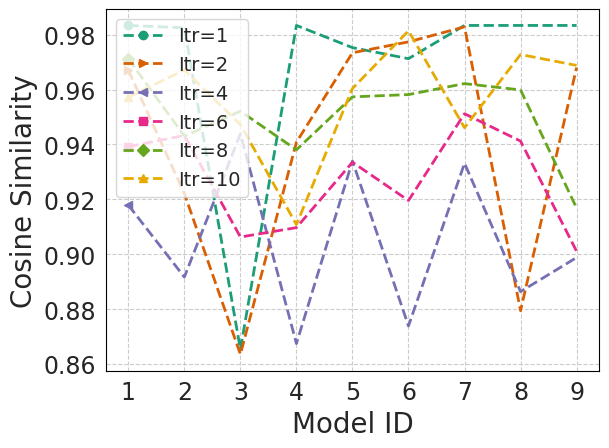

In [50]:
draw_graph(x_val=[i+1 for i in range(9)], y_vals=[cos_sim_0,cos_sim_1, cos_sim_3,cos_sim_5,cos_sim_7, cos_sim_9], markers=['o','>','<','s','D','^'],x_label='Model ID', y_label='Cosine Similarity',
           legend=['Itr=1','Itr=2','Itr=4','Itr=6','Itr=8','Itr=10'])

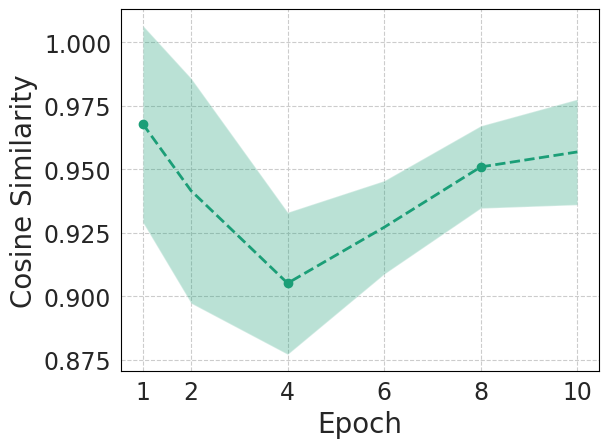

In [51]:
draw_graph(x_val=[1,2,4,6,8,10], y_vals=[cos_sim_mean_vals], markers=['o','>','<','s','D','^'],x_label='Epoch', y_label='Cosine Similarity',
          std_vals=[cos_sim_stdev_vals], markevery=2)